In [1]:
import pandas as pd

df = pd.read_pickle('sokureplays.pkl')
characters = ['aya', 'youmu', 'iku', 'reimu', 'reisen', 'remilia', 'marisa',
        'suika', 'tenshi', 'yuyuko', 'komachi', 'suwako', 'sakuya',
        'utsuho', 'meiling', 'yukari', 'patchouli', 'alice', 'cirno',
        'sanae']

df_no_mirror_matches = df.query("server_character != client_character")
df_mirror_matches = df.query("server_character == client_character")

In [2]:
df_server = df[['server_player_id','server_rounds', 'server_character', 'client_character', 'server_cards', 'server_nick', 'server_country']].copy()
df_client = df[['client_player_id','client_rounds', 'client_character', 'server_character', 'client_cards', 'client_nick', 'client_country']].copy()

df_server.rename(columns={'server_player_id': 'player_id', 'server_rounds': 'rounds', 'server_character': 'character', 'client_character': 'opponent', 'server_cards': 'cards', 'server_nick': 'nick', 'server_country': 'country'}, inplace=True)
df_client.rename(columns={'client_player_id': 'player_id', 'client_rounds': 'rounds', 'client_character': 'character', 'server_character': 'opponent', 'client_cards': 'cards', 'client_nick': 'nick', 'client_country': 'country'}, inplace=True)

join = pd.concat([df_server, df_client], ignore_index=True)

df = join

In [3]:
char_df = df.query("character == 'tenshi'")

C:\Users\RE\AppData\Local\Temp\ipykernel_16888\3768477774.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_df['cards_str'] = char_df['cards'].apply(lambda x: ' '.join(map(str, x)))


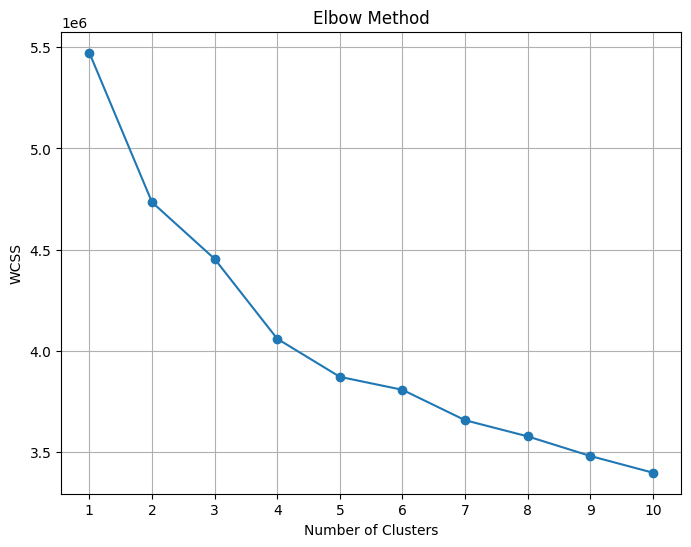

Optimal number of clusters: 4


C:\Users\RE\AppData\Local\Temp\ipykernel_16888\3768477774.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  char_df['cluster'] = cluster_labels


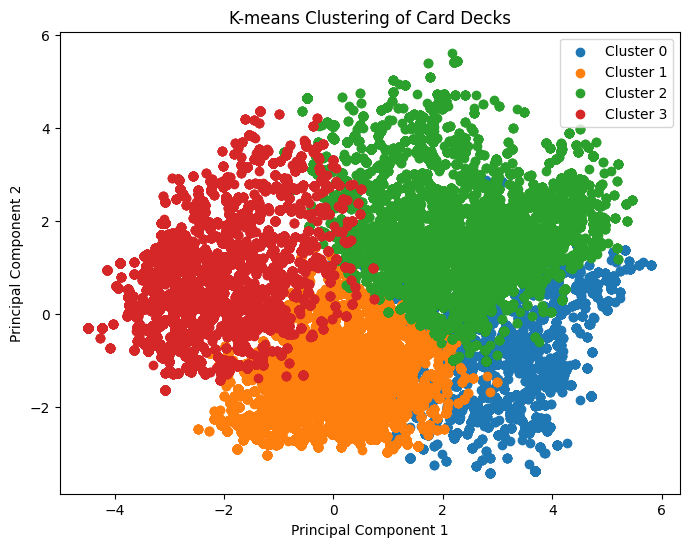

In [4]:
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from kneed import KneeLocator
import numpy as np

# Convert list of cards to string representation
char_df['cards_str'] = char_df['cards'].apply(lambda x: ' '.join(map(str, x)))

# Vectorize the text data
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(char_df['cards_str'])

# Determine the optimal number of clusters using the elbow method
wcss = []
max_k = 10  # maximum number of clusters to consider
for k in range(1, max_k + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)

# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(range(1, max_k + 1), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.xticks(np.arange(1, max_k + 1))
plt.grid(True)
plt.show()

# Choose the optimal number of clusters (e.g., based on the elbow point)
kl = KneeLocator(range(1, max_k + 1), wcss, curve='convex', direction='decreasing')
optimal_k = kl.elbow

print("Optimal number of clusters:", optimal_k)

# Perform K-means clustering with the optimal number of clusters
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
kmeans.fit(X)

# Get cluster labels
cluster_labels = kmeans.labels_

# Add cluster labels to DataFrame
char_df['cluster'] = cluster_labels

# Reduce data to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(X.toarray())

components = pca.components_

# Plot the clusters
plt.figure(figsize=(8, 6))
for i in range(optimal_k):
    plt.scatter(X_reduced[cluster_labels == i, 0], X_reduced[cluster_labels == i, 1], label=f'Cluster {i}')
plt.title('K-means Clustering of Card Decks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [8]:
# Get the centroids of the clusters
centroids = kmeans.cluster_centers_

# Convert centroids to integer representation of card counts
centroid_counts = centroids.astype(int)

# Reverse the vectorizer to map feature indices to words (card representations)
reverse_vocab = {v: k for k, v in vectorizer.vocabulary_.items()}

# Convert centroid counts to card representations
centroid_cards = [[reverse_vocab[i] for i, count in enumerate(centroid) if count > 0] for centroid in centroid_counts]

# Count the number of data points in each cluster
cluster_sizes = char_df['cluster'].value_counts()

from IPython.display import Image, display
from IPython.display import display, HTML

# Function to display PNG image for a card
def display_card_image(card):
    filename = f"cards/14/{card}.png"
    return f'<img src="{filename}" style="display:inline-block; margin:1px 5px;"/>'

# Iterate over clusters and display images for most frequent cards
for i, cards in enumerate(centroid_cards):
    html_content = f"""
    <h2>Cluster {i}:</h2>
    <p>Most frequent cards: {cards}</p>
    <p>Cluster size: {cluster_sizes[i]} data points</p>
    <p>Displaying images for most frequent cards:</p>
    {''.join([display_card_image(card) for card in cards])}
    """
    display(HTML(html_content))
